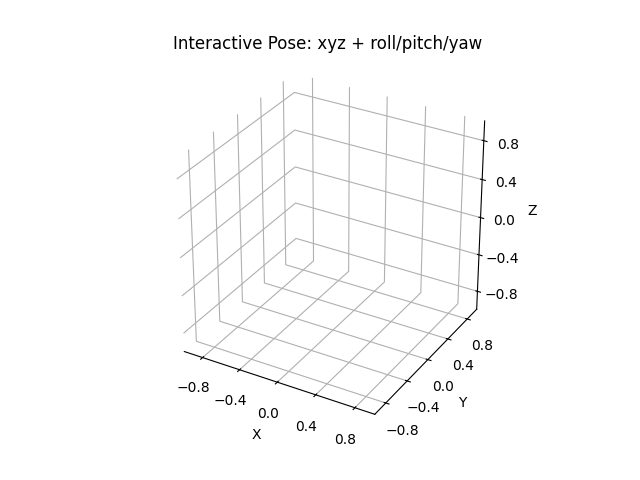

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import plot_transform, transform_from
from pytransform3d.rotations import matrix_from_euler

# --- Figure & Axes ---
ax = make_3d_axis(ax_s=1.0)
ax.set_title("Interactive Pose: xyz + roll/pitch/yaw")
ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
ax.set_box_aspect([1,1,1])

In [2]:
# --- Widgets ---
sx=w.FloatSlider(min=-1,max=1,step=0.01,description='x',value=0.0)
sy=w.FloatSlider(min=-1,max=1,step=0.01,description='y',value=0.0)
sz=w.FloatSlider(min=-1,max=1,step=0.01,description='z',value=0.0)
sroll=w.FloatSlider(min=-180,max=180,step=1,description='roll°',value=0.0)
spitch=w.FloatSlider(min=-180,max=180,step=1,description='pitch°',value=0.0)
syaw=w.FloatSlider(min=-180,max=180,step=1,description='yaw°',value=0.0)
L=w.FloatSlider(min=0.05,max=0.5,step=0.01,value=0.2,description='axis_len')
show_world=w.Checkbox(value=True,description='显示世界坐标轴')
reset_btn=w.Button(description='重置')
# 在原来那一格 cell 里加入这些控件
use_lh = w.Checkbox(value=False, description='左手系输入')
flip_axis = w.Dropdown(options=['x','y','z'], value='z', description='左手系由哪轴翻转')

def mirror4(flip='z'):
    """返回 4x4 镜像矩阵 S，翻转 x/y/z 之一（构造左手系）"""
    S = np.eye(4)
    i = {'x':0, 'y':1, 'z':2}[flip]
    S[i, i] = -1.0
    return S

def set_axes(ax, lim=(-1,1)):
    lo, hi = lim
    # 不反转任何轴的数轴方向
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi); ax.set_zlim(lo, hi)
    ax.set_box_aspect([1,1,1])

# 选轴镜像矩阵（把该轴取反）
def mirror_matrix(flip='z'):
    M = np.eye(4)
    if flip == 'x': M[0, 0] = -1.0
    elif flip == 'y': M[1, 1] = -1.0
    else: M[2, 2] = -1.0
    return M

# 让三维数轴方向也与左手系一致
def apply_axes_handness(ax, lim=(-1.0, 1.0), use_lh=False, flip='z'):
    (lo, hi) = lim
    if use_lh:
        if flip == 'x':
            ax.set_xlim(hi, lo)   # 反转 X
            ax.set_ylim(lo, hi)
            ax.set_zlim(lo, hi)
        elif flip == 'y':
            ax.set_xlim(lo, hi)
            ax.set_ylim(hi, lo)   # 反转 Y
            ax.set_zlim(lo, hi)
        else:  # 'z'
            ax.set_xlim(lo, hi)
            ax.set_ylim(lo, hi)
            ax.set_zlim(hi, lo)   # 反转 Z
    else:
        ax.set_xlim(lo, hi); ax.set_ylim(lo, hi); ax.set_zlim(lo, hi)
    ax.set_box_aspect([1, 1, 1])

def rpy_lh_to_rh_matrix(r, p, y, flip='z'):
    # r,p,y 已是弧度，顺序 xyz
    if flip == 'z':
        return matrix_from_euler([-r, -p,  y],0,1,2,True)
    elif flip == 'x':
        return matrix_from_euler([ r, -p, -y],0,1,2,True)
    elif flip == 'y':
        return matrix_from_euler([-r,  p, -y],0,1,2,True)
    else:
        raise ValueError("flip must be x/y/z")

def t_lh_to_rh(t, flip='z'):
    t = np.array(t, dtype=float)
    if flip == 'z': t[2] = -t[2]
    elif flip == 'x': t[0] = -t[0]
    elif flip == 'y': t[1] = -t[1]
    return t

def draw_pose(*_):
    ax.cla()
    ax.set_title(("LH" if use_lh.value else "RH") + " world · xyz + rpy")
    set_axes(ax, (-1, 1))

    # 角度 -> 弧度（数值含义：围绕 X/Y/Z 的 rpy）
    r, p, y = np.deg2rad([sroll.value, spitch.value, syaw.value])

    if use_lh.value:
        S = mirror4(flip_axis.value)

        # 1) 世界轴：左手世界坐标 = S
        if show_world.value:
            plot_transform(ax, A2B=S, s=0.25, strict_check=False)

        # 2) 物体：先用“左手 rpy/xyz”直接构 T_LH（注意：角度不取反）
        R_lh = matrix_from_euler([r, p, y],0,1,2,True)          # 在 LH 基底里的旋转
        t_lh = np.array([sx.value, sy.value, sz.value])     # LH 平移
        T_lh = transform_from(R_lh, t_lh)

        # 3) 嵌入到 RH 画布：A2B_obj = S · T_LH
        plot_transform(ax, A2B=S @ T_lh, s=L.value, strict_check=False)

    else:
        # 右手系：常规画法
        if show_world.value:
            plot_transform(ax, A2B=np.eye(4), s=0.25)
        R_rh = matrix_from_euler([r, p, y],0,1,2,True) 
        t_rh = np.array([sx.value, sy.value, sz.value])
        T = transform_from(R_rh, t_rh)
        plot_transform(ax, A2B=T, s=L.value)

    ax.figure.canvas.draw_idle()


def on_reset(_):
    sx.value = sy.value = sz.value = 0.0
    sroll.value = spitch.value = syaw.value = 0.0
    L.value = 0.2
    show_world.value = True

In [3]:
for wid in (sx,sy,sz,sroll,spitch,syaw,L,show_world):
    wid.observe(draw_pose, names='value')
reset_btn.on_click(on_reset)

# 放到你的 controls 里（例如）
controls = w.VBox([
    w.HBox([sx, sy, sz]),
    w.HBox([sroll, spitch, syaw]),
    w.HBox([L, show_world, reset_btn]),
    w.HBox([use_lh, flip_axis]),   # ← 新增
])

# 关键：把“图像画布”当成一个 widget 和控件一起显示
app = w.VBox([controls, ax.figure.canvas])   # 想左右排就换成 w.HBox([...])
display(app)

draw_pose()

# 红色x 绿色y 蓝色z